# Attention seq2seq using GloVe embeddings, not working yet. 

In [1]:
from attention import AttentionLayer
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt
%matplotlib
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Using matplotlib backend: TkAgg


In [2]:
data=pd.read_csv("..\\Data\\model_training\\100000_samples_Reviews.csv")
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na rows

In [3]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [4]:
# data=data.rename(columns = {'article': 'Text', 'title': 'Summary'})
data.head()

,Text,Summary
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","""Delight"" says it all"
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,Cough Medicine
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",Great taffy


In [5]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [6]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [7]:
for i in range(2):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print()

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: good quality dog food 

Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: not as advertised 



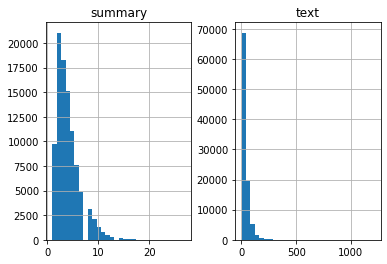

In [8]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [9]:
max_len_text=30
max_len_summary=8

In [10]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [11]:
# Apply start of sentence/ end of sentence tokens to summary, used for 
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok
...,...,...
52254,favorite coffee also best price found thanks amazon com,sostok great tasting coffee eostok
52255,generally like millstone coffees one major disappointment weak flavor taste drinker weak non acidic coffee might find liking,sostok millstone kona bad blend eostok
52256,disappointed trying use mixing fresh roast beans grinding seem like old stock beans practically dessicated fresh roasted sheen bean speak lot like typical pack hotel coffee would recommend reorder,sostok not very fresh beans are very dry eostok
52257,enjoy blend fan starbuck coffee enjoy looking lighter roast good price flavor simply worst kona blend ever tried maybe taste different moving different blend,sostok really did not like this one eostok


In [12]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [13]:
y_val[0:10]

array(['sostok great coffee  eostok',
       'sostok iby far the best gluten free pasta  eostok',
       'sostok misleading  eostok', 'sostok quality tea  eostok',
       'sostok good coffee  eostok',
       'sostok my favorite cup tea blend  eostok',
       'sostok good food  eostok', 'sostok great pancakes  eostok',
       'sostok light and tasty  eostok', 'sostok powder cereal  eostok'],
      dtype=object)

## X: Text tokenizer

In [14]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4 # threshold = 4. Word whose count is below 4 is considered as a rare word
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.13882696594665
Total Coverage of rare words: 2.7712041060446184


In [15]:
tot_cnt-cnt

8810

In [16]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # for the vocabulary
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

8811

In [17]:
x_tr

array([[ 504,  112,   86, ...,    0,    0,    0],
       [  74,  153, 2113, ...,  140,   72,   87],
       [ 150,    2,   68, ...,    0,    0,    0],
       ...,
       [ 454,  573,  122, ...,    0,    0,    0],
       [   6,  346,  953, ...,    0,    0,    0],
       [  12,   50,  586, ...,    0,    0,    0]])

## Y: Summary Tokenizer

In [18]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6 # threshold = 6. Word whose count is below 6 is considered as a rare word, since summaries are less.
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 77.7399029025927
Total Coverage of rare words: 5.128902602411595


In [19]:
tot_cnt-cnt

2155

In [20]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
y_voc

2156

In [21]:
y_tokenizer.word_counts['sostok']-len(y_tr) # should be 0, check if there are any sostok's in the word list. 

0

In [22]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [23]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## GloVe embeddings

In [24]:
from load_glove_embeddings import load_glove_embeddings # local function from .py file
glove_dimension = 50
import time
timer_start = time.time()
# word2index, embedding_matrix = load_glove_embeddings('Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
word2index, embedding_matrix = load_glove_embeddings('../Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)

print('Found %s word vectors.' % len(word2index))
print("Creating embeddings_index took", round(time.time() - timer_start, 1), "seconds.")
del timer_start

Found 400000 word vectors.
Creating embeddings_index took 11.6 seconds.


In [25]:
embedding_matrix

array([[ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.013441  ,  0.23682   , -0.16899   , ..., -0.56656998,
         0.044691  ,  0.30392   ],
       [ 0.15164   ,  0.30177   , -0.16763   , ..., -0.35652   ,
         0.016413  ,  0.10216   ],
       ...,
       [-0.51181   ,  0.058706  ,  1.09130001, ..., -0.25003001,
        -1.125     ,  1.58630002],
       [-0.75897998, -0.47426   ,  0.47369999, ...,  0.78953999,
        -0.014116  ,  0.64480001],
       [ 0.072617  , -0.51393002,  0.47279999, ..., -0.18907   ,
        -0.59021002,  0.55558997]])

In [26]:
from itertools import islice
list(islice(word2index.items(), 10))

[('the', 0),
 (',', 1),
 ('.', 2),
 ('of', 3),
 ('to', 4),
 ('and', 5),
 ('in', 6),
 ('a', 7),
 ('"', 8),
 ("'s", 9)]

In [27]:
def embedding_matrix_creater(embedding_dimention, word_index): 
    """
    Uses GloVe as a global word embedding. 
    
    embedding_dimention: usually in the title of glove.6D.'embedding_dimention', in this notebook use 50. 
    word_index: the input word embeddings
    
    returns: a local embedding matrix, to be input as weights [embedding] for the constructor
        for keras' Embedding object. 
    """
    local_embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = word2index.get(word) # from cell above, from glove.
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            local_embedding_matrix[i] = embedding_vector
    return local_embedding_matrix

In [28]:
len(x_tokenizer.word_index)

26018

In [29]:
dict(islice(x_tokenizer.word_index.items(), 5))

{'great': 1, 'good': 2, 'like': 3, 'love': 4, 'taste': 5}

In [30]:
print('x_tokenizer.num_words:', x_tokenizer.num_words)
print('x_voc:', x_voc)

x_tokenizer.num_words: 8810
x_voc: 8811


In [31]:
text_embedding_matrix = embedding_matrix_creater(glove_dimension, 
        word_index=dict(islice(x_tokenizer.word_index.items(), x_tokenizer.num_words+1)))
print(text_embedding_matrix.shape)

sum_embedding_matrix = embedding_matrix_creater(glove_dimension, 
        word_index=dict(islice(y_tokenizer.word_index.items(), y_tokenizer.num_words+1)))
print(sum_embedding_matrix.shape)

encoder_embedding_layer = Embedding(input_dim = int(text_embedding_matrix.shape[0]), # vocab size
                                    output_dim = int(text_embedding_matrix.shape[1]), # embedding dimension
                                    input_length = max_len_text, # sequence length
                                    weights = [text_embedding_matrix],
                                    trainable = False) # False because these embeddings have already been trained. 

decoder_embedding_layer = Embedding(input_dim = int(sum_embedding_matrix.shape[0]),
                                    output_dim = int(sum_embedding_matrix.shape[1]),
                                    input_length = max_len_summary,
                                    weights = [sum_embedding_matrix],
                                    trainable = False) # False because these embeddings have already been trained. 

(8812, 50)
(2157, 50)


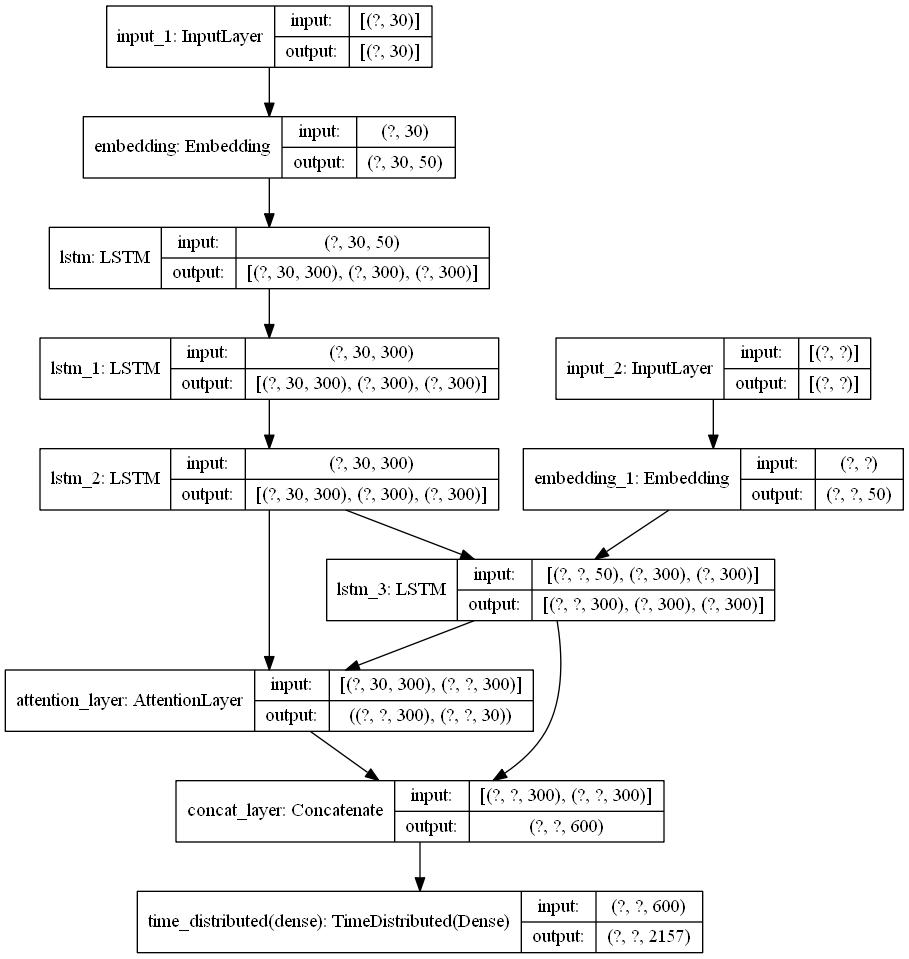

In [33]:
# (number of inputs, length of the output sentence, the number of words in the output)
from keras import backend as K 
K.clear_session()


latent_dim = 300
# embedding_dim=100 # OLD, can be glove dimension now

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
# enc_emb =  Embedding(x_voc_size, embedding_dim,trainable=True)(encoder_inputs) # OLD
enc_emb = encoder_embedding_layer(encoder_inputs) # NEW

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
# dec_emb_layer = Embedding(y_voc_size, embedding_dim,trainable=True) # OLD
# dec_emb = dec_emb_layer(decoder_inputs) # OLD
dec_emb = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(int(sum_embedding_matrix.shape[0]), activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model_glove.png', show_shapes=True)

In [34]:
y_val.shape

(5100, 8)

In [47]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=2,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 45840 samples, validate on 5100 samples
Epoch 1/2
45840/45840 [==============================] - 610s 13ms/sample - loss: 2.8536 - val_loss: 2.7787
Epoch 2/2
45840/45840 [==============================] - 566s 12ms/sample - loss: 2.7604 - val_loss: 2.7626


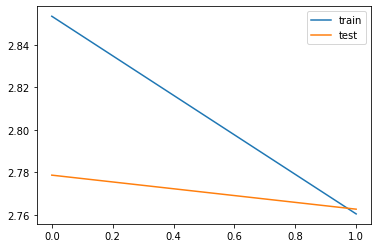

In [48]:
from matplotlib import pyplot 
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend()
plt.show()

## Inferernce, decoder

In [49]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

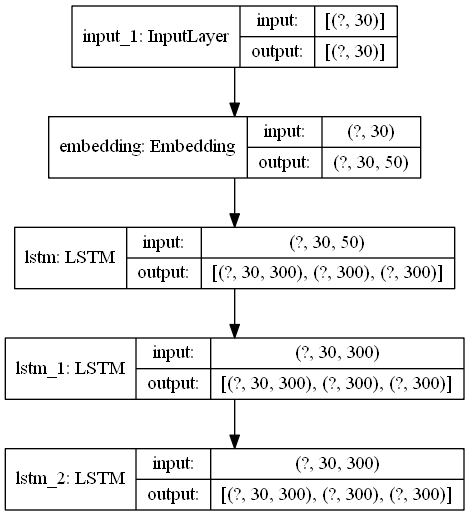

In [50]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
tf.keras.utils.plot_model(encoder_model, to_file='model_glove_inf_enc.png', show_shapes=True)

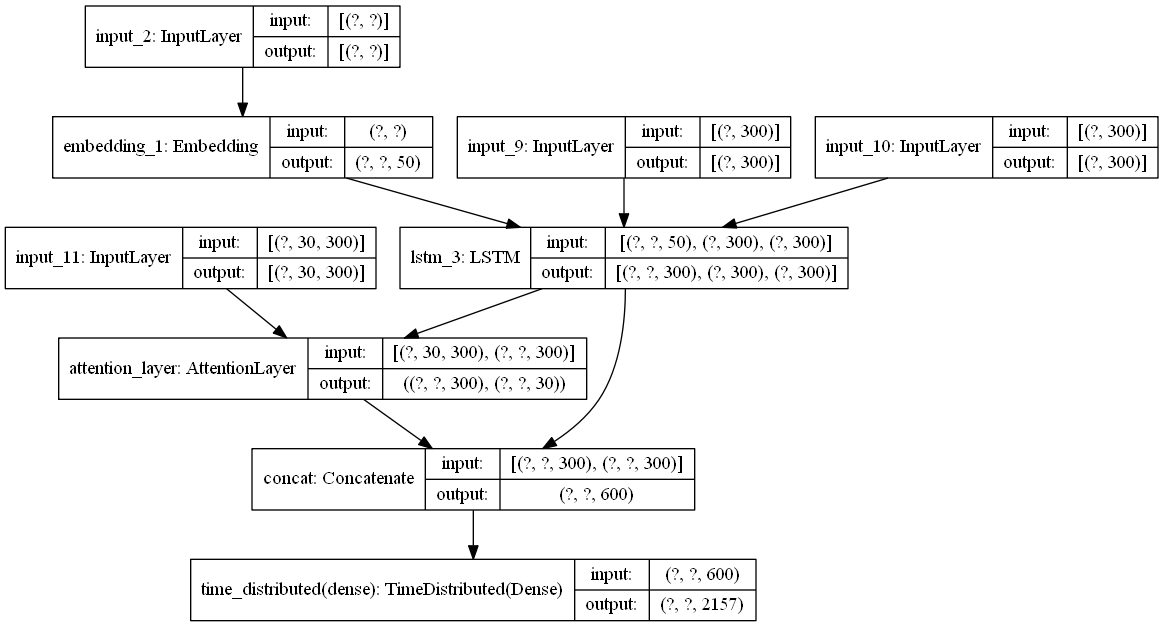

In [51]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= decoder_embedding_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
tf.keras.utils.plot_model(decoder_model, to_file='model_glove_inf_dec.png', show_shapes=True)

In [52]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [53]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print('e_out:', e_out[0][0][0])
    print('e_h:', e_h[0][0])
    print('e_c:', e_c[0][0])
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']
    # works fine
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
#         print("output_tokens:", output_tokens)
    
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]
        print('sample token:', sampled_token)
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [54]:
for i in range(0,20):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print()
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
    print("________________________________________________________")
    print("\n")

Review: oatmeal old hard parts bad taste throw away never order 
Original summary: bad 

e_out: -0.033528727
e_h: 0.4725772
e_c: 4.1316547
sample token: great
sample token: eostok
Predicted summary:  great
________________________________________________________


Review: always thought lentils beans old people love amy kitchen soups wanted try good thing love flavor perfect consistency perfect tastes excellent sometimes even squirt lime juice spoon eating mix bit 
Original summary: lentils are not just for old people 

e_out: -0.033612676
e_h: 0.4049182
e_c: 3.7690532
sample token: great
sample token: eostok
Predicted summary:  great
________________________________________________________


Review: pretty good stuff found cheaper local grocery store buying amazon best canned chowder ever purchased nothing good home made works quick snack 
Original summary: clam chowder 

e_out: -0.033600207
e_h: 0.41881016
e_c: 3.751626
sample token: great
sample token: eostok
Predicted summary:  gre

In [48]:
for i in range(3):
    print(x_tr[i])

[ 504  112   86 2538  113    5  618  224   84   36    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[  74  153 2113  334  112  218    4 2773  875  836  298   35    2  175
    4    8   52  606   52   39   70  429   38 4711  884  327 1416  140
   72   87]
[ 150    2   68   42  207  108  156   46   92   17   12  550 3077   54
  127  244    2  217   59  219  208   57    0    0    0    0    0    0
    0    0]


In [49]:
for i in range(3):
    print(y_tr[i])

[ 1 73  2  0  0  0  0  0]
[1742   49    9   45    7  170  574    2]
[   1 1915 1743    2    0    0    0    0]


## Save model. 

In [ ]:
# # Save model.
# model_json = model.to_json()
# with open('model_v1.json',"w") as json_file:
#     json_file.write(model_json)
# model.save_weights('model_v1.h5')
# print("Saved Model")

In [ ]:
# # Note: may be unable to load model since a custom "attention layer" is used. 
# from keras.models import model_from_json
# # load json and create model
# json_file = open('model_v1.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model_v1.h5")
# print("Loaded model from disk")

In [ ]:
# decoder_state_input_h.shape

In [ ]:
# x_tr[i].reshape(1,max_len_text)